Garin Jankowski

# Link Prediction on a Kelp Forest Food Web

In [1]:
import pandas as pd
import torch
import torch_geometric
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import negative_sampling
from torch_geometric.nn import SAGEConv, Linear

## Retrieving the Data

In [2]:
nodes = pd.read_csv('../foodwebdata/1_Nodes.csv')
edges = pd.read_csv('../foodwebdata/2_Links.csv')

In [3]:
# create a map between the df index and NodeIDs so that there are no skipped numbers in the IDs
nodes_id_map = pd.Series(nodes.index,index=nodes['Node.ID']).to_dict()
# choose the node features being used
nodes = nodes[['stageID', 'Stage', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Habitat_Site', 'Consumer.Strategy', 'Consumer.Type', 'Mobility', 'Life.Cycle']]
nodes.head()

,stageID,Stage,Phylum,Class,Order,Family,Genus,Habitat_Site,Consumer.Strategy,Consumer.Type,Mobility,Life.Cycle
0,1,Adult,Echinodermata,Asteroidea,Valvatida,Asteropseidae,Dermasterias,rock,Predator,Predator,Mobile,1
1,1,Adult,Echinodermata,Asteroidea,Forcipulatida,Asteriidae,Orthasterias,rock,Predator,Predator,Mobile,1
2,1,Adult,Echinodermata,Asteroidea,Valvatida,Asterinidae,Patiria,rock,Omnivore,Predator,Mobile,1
3,1,Adult,Echinodermata,Asteroidea,Forcipulatida,Asteriidae,Pisaster,rock,Predator,Predator,Mobile,1
4,1,Adult,Echinodermata,Asteroidea,Forcipulatida,Asteriidae,Pisaster,rock,Predator,Predator,Mobile,1


In [4]:
# choose the edge features being used
edges = edges[['consumers', 'resources', 'Consumer.Interaction.Code', 'Feeding.Site']]
# change the NodeIDs to the new ones using the mapping
edges = edges.replace({'consumers': nodes_id_map})
edges = edges.replace({'resources': nodes_id_map})
edges.head()

,consumers,resources,Consumer.Interaction.Code,Feeding.Site
0,6,0,1,3.0
1,6,1,1,3.0
2,6,2,1,3.0
3,461,2,1,3.0
4,6,3,1,3.0


In [5]:
# transform the features into categorial features and one-hot encode them
nodes = nodes.astype('category')
nodes_dummies = pd.get_dummies(nodes)

edge_cats = ['Consumer.Interaction.Code', 'Feeding.Site']
edges[edge_cats] = edges[edge_cats].astype('category')
edges_dummies = pd.get_dummies(edges)

In [6]:
print(nodes_dummies.info())
print(edges_dummies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098 entries, 0 to 1097
Columns: 1502 entries, stageID_0 to Life.Cycle_7
dtypes: uint8(1502)
memory usage: 1.6 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21956 entries, 0 to 21955
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   consumers                     21956 non-null  int64
 1   resources                     21956 non-null  int64
 2   Consumer.Interaction.Code_1   21956 non-null  uint8
 3   Consumer.Interaction.Code_3   21956 non-null  uint8
 4   Consumer.Interaction.Code_4   21956 non-null  uint8
 5   Consumer.Interaction.Code_5   21956 non-null  uint8
 6   Consumer.Interaction.Code_6   21956 non-null  uint8
 7   Consumer.Interaction.Code_12  21956 non-null  uint8
 8   Consumer.Interaction.Code_14  21956 non-null  uint8
 9   Consumer.Interaction.Code_20  21956 non-null  uint8
 10  Feeding.Site_1.0              219

## Prepare the Data Object

In [7]:
x = torch.tensor(nodes_dummies.values)
edge_index = torch.tensor(edges_dummies[['consumers', 'resources']].values).T
edge_attr = torch.tensor(edges_dummies.drop(['consumers', 'resources'], axis=1).values)

In [8]:
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
data

Data(x=[1098, 1502], edge_index=[2, 21956], edge_attr=[21956, 11])

In [9]:
# split the data into training, validation, and testing sets
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.2,
    disjoint_train_ratio=0.3,
    # neg_sampling_ratio=2,
    add_negative_train_samples=False,
)

train_data, val_data, test_data = transform(data)
print(train_data)
print(val_data)
print(test_data)

Data(x=[1098, 1502], edge_index=[2, 10759], edge_attr=[10759, 11], edge_label=[4611], edge_label_index=[2, 4611])
Data(x=[1098, 1502], edge_index=[2, 15370], edge_attr=[15370, 11], edge_label=[4390], edge_label_index=[2, 4390])
Data(x=[1098, 1502], edge_index=[2, 17565], edge_attr=[17565, 11], edge_label=[8782], edge_label_index=[2, 8782])


## Create GNN to Learn Node Embeddings and MLP to Predict Edges

In [10]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = SAGEConv(-1, 64)
        self.conv2 = SAGEConv(64, 32)
        self.conv3 = SAGEConv(32, 32)
        self.linear = Linear(32, 8)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.linear(x)
        return x

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

class LinkPrediction(torch.nn.Module):
    def __init__(self):
        super(LinkPrediction, self).__init__()

        self.linear1 = Linear(8, 50)
        self.linear2 = Linear(50, 10)
        self.linear3 = Linear(10, 1)
    
    def reset_parameters(self):
        self.linear1.reset_parameters()
        self.linear2.reset_parameters()
        self.linear3.reset_parameters()
    
    def forward(self, x_i, x_j):
        x = x_i * x_j
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return torch.sigmoid(x)

## Train Models on Data

In [11]:

# initialize embeddings and models
embedding = torch.nn.Embedding(data.num_nodes, data.num_node_features)
model = GNN()
predictor = LinkPrediction()

# define optimizer
optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()) + list(embedding.parameters()),
    lr=5e-4
)

# prepare DataLoaders
train_loader = DataLoader([train_data], 64, shuffle=True)
test_loader = DataLoader([test_data], 64, shuffle=True)

# define loss
def loss_fn(pos_pred, neg_pred):
    return -torch.log(pos_pred + 1e-15).mean() - torch.log(1 - neg_pred + 1e-15).mean()

def train(data):
    model.train()
    predictor.train()

    for batch in train_loader:
        optimizer.zero_grad()
        emb = model(embedding.weight, data.edge_index)

        # evaluate positive edges (the existing edges)
        pos_edge = batch.edge_index
        pos_pred = predictor(emb[pos_edge[0]], emb[pos_edge[1]])

        # evaluate negativ edges (create nonexistent edges to evaluate on)
        neg_edge = negative_sampling(data.edge_index, num_nodes=emb.shape[0],
                                     num_neg_samples=pos_edge.size()[1], method='dense')
        neg_pred = predictor(emb[neg_edge[0]], emb[neg_edge[1]])

        loss = loss_fn(pos_pred, neg_pred)
        loss.backward()
        optimizer.step()
    
    # validate
    loss, _, _, _ = test(val_data)
    return loss

def test(data):
    model.eval()
    predictor.eval()

    emb = model(embedding.weight, data.edge_index)

    # go through the positive and negative data
    pos_edge = data.edge_index
    pos_pred = predictor(emb[pos_edge[0]], emb[pos_edge[1]])

    neg_edge = negative_sampling(data.edge_index, num_nodes=emb.shape[0],
                                    num_neg_samples=pos_edge.size()[1], method='dense')
    neg_pred = predictor(emb[neg_edge[0]], emb[neg_edge[1]])

    # compute metrics
    loss = loss_fn(pos_pred, neg_pred)
    pos_correct = torch.sum(torch.round(pos_pred))
    neg_correct = torch.sum(torch.ones(neg_pred.size()) - torch.round(neg_pred))
    acc = (pos_correct + neg_correct)/(pos_pred.size()[0]+neg_pred.size()[0])
    prec = pos_correct/(pos_correct+(neg_pred.size()[0]-neg_correct))
    recall = pos_correct/pos_pred.size()[0]

    return loss, acc, prec, recall


# train over 100 epochs
losses = []
for epoch in range(100):
    loss = train(data)
    losses.append(loss)
    if epoch % 25 == 0:
        print(f'Epoch {epoch}\tValidation Loss: {loss}')
print(f'Finished\tValidation Loss: {loss}')

Epoch 0	Validation Loss: 1.404681921005249
Epoch 25	Validation Loss: 1.1847882270812988
Epoch 50	Validation Loss: 0.8272663354873657
Epoch 75	Validation Loss: 0.6616246700286865
Finished	Validation Loss: 0.6270456910133362


## Test on Testing Set

In [12]:
loss, acc, prec, recall = test(test_data)
print(f'Accuracy: {acc}')
print(f'Precision: {prec}')
print(f'Recall: {recall}')

Accuracy: 0.8816680908203125
Precision: 0.8507009744644165
Recall: 0.9258183836936951


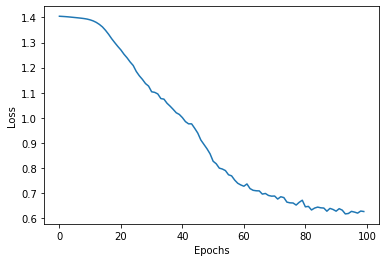

In [13]:
import matplotlib.pyplot as plt

with torch.no_grad():
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.plot([i for i in range(len(losses))], losses)